In [2]:
from statsbombpy import sb
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from mplsoccer import Pitch

In [26]:
#Get all UEFA EURO 2024 matches
matches = sb.matches(season_id=282,competition_id=55)


spain_matches = matches[
    (matches['home_team'] == 'Spain') | (matches['away_team'] == 'Spain')
].copy()

spain_matches[['match_id', 'home_team', 'away_team', 'match_date']]

match_id home_team away_team  match_date
1    3943043     Spain   England  2024-07-14
2    3942752     Spain    France  2024-07-09
8    3942226     Spain   Germany  2024-07-05
15   3941018     Spain   Georgia  2024-06-30
18   3930179   Albania     Spain  2024-06-24
23   3930172     Spain     Italy  2024-06-20
48   3930160     Spain   Croatia  2024-06-15

In [41]:
def plot_pass_network(match_id,team_name,min_passes=5):
    #Load event data
    events = sb.events(match_id=match_id)
    passes = events[
        (events['type']=='Pass') & 
        (events['team']==team_name) &
        (events['pass_type']!='Throw-In') & 
        (events['pass_outcome'].isna())
    ]

    passes = passes[['player', 'pass_recipient', 'location', 'pass_end_location']].dropna()
    passes[['x', 'y']] = pd.DataFrame(passes['location'].tolist(), index=passes.index)
    passes[['end_x', 'end_y']] = pd.DataFrame(passes['pass_end_location'].tolist(), index=passes.index)

    # Network graph
    G = nx.DiGraph()
    for _, row in passes.iterrows():
        passer = row['player']
        recipient = row['pass_recipient']
        if G.has_edge(passer, recipient):
            G[passer][recipient]['weight'] += 1
        else:
            G.add_edge(passer, recipient, weight=1)

    # Remove weak edges
    G.remove_edges_from([(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_passes])

    #Compute centrality
    centrality = nx.degree_centrality(G)
    
    avg_locs = passes.groupby('player')[['x', 'y']].mean()

    pitch = Pitch(pitch_color='grass',line_color='white',stripe=True)
    fig, ax = pitch.draw(figsize=(10, 7))

    for player, (x, y) in avg_locs.iterrows():
        size = centrality.get(player, 0) * 3000
        ax.scatter(x, y, s=size, color='skyblue', edgecolor='black', zorder=3)
        ax.text(x, y, player.split()[0], fontsize=9, ha='center', va='center', zorder=4)

    for u, v, d in G.edges(data=True):
        if u in avg_locs.index and v in avg_locs.index:
            x1, y1 = avg_locs.loc[u]
            x2, y2 = avg_locs.loc[v]
            ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                        arrowprops=dict(arrowstyle="->", lw=d['weight'] * 0.3, color='pink',alpha=0.8),
                        zorder=2)

    teams = events['team'].unique()

    opp_team = [t for t in teams if t!='Spain'][0]

    ax.set_title(f"{team_name} Pass Network vs. {opp_team}", fontsize=16)
    plt.show()
    plt.close(fig)

    # Print top 5 most central players
    top_5 = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nTop 5 players by degree centrality vs. {opp_team}:")
    for rank, (player, score) in enumerate(top_5, 1):
        print(f"{rank}. {player}: {score:.3f}")

    return centrality



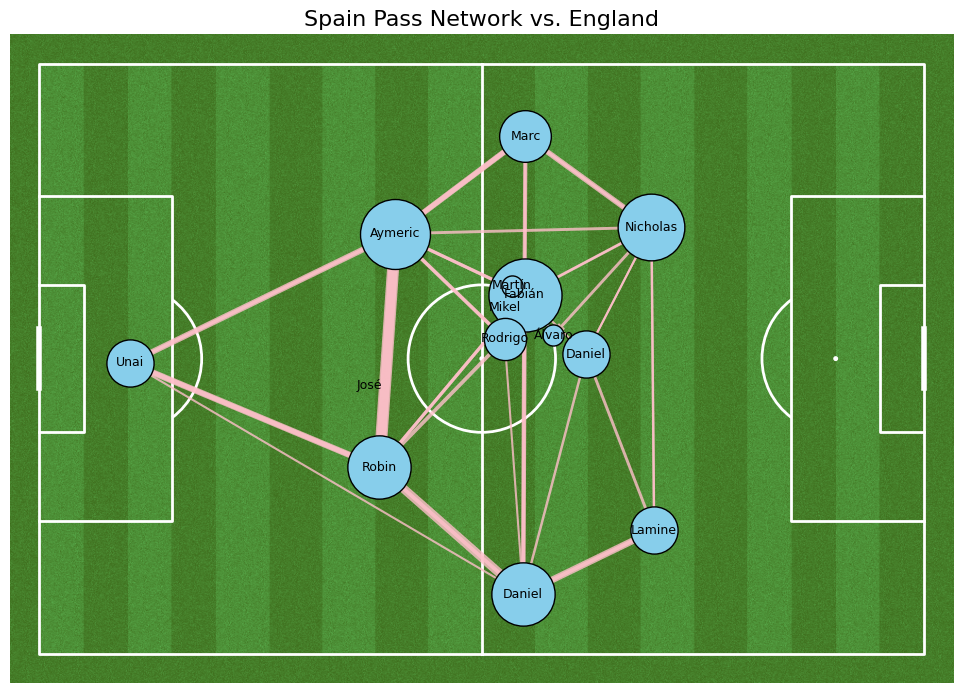


Top 5 players by degree centrality vs. England:
1. Fabián Ruiz Peña: 0.923
2. Aymeric Laporte: 0.846
3. Nicholas Williams Arthuer: 0.769
4. Robin Aime Robert Le Normand: 0.692
5. Daniel Carvajal Ramos: 0.692


{'Unai Simón Mendibil': 0.38461538461538464,
 'Robin Aime Robert Le Normand': 0.6923076923076923,
 'Daniel Carvajal Ramos': 0.6923076923076923,
 'Daniel Olmo Carvajal': 0.38461538461538464,
 'Rodrigo Hernández Cascante': 0.3076923076923077,
 'Aymeric Laporte': 0.8461538461538463,
 'Lamine Yamal Nasraoui Ebana': 0.38461538461538464,
 'Álvaro Borja Morata Martín': 0.07692307692307693,
 'Marc Cucurella Saseta': 0.46153846153846156,
 'Fabián Ruiz Peña': 0.9230769230769231,
 'Nicholas Williams Arthuer': 0.7692307692307693,
 'Martín Zubimendi Ibáñez': 0.07692307692307693,
 'Mikel Oyarzabal Ugarte': 0.0,
 'José Ignacio Fernández Iglesias': 0.0}

In [42]:
plot_pass_network(match_id=3943043,team_name='Spain')
#plt.close(fig)

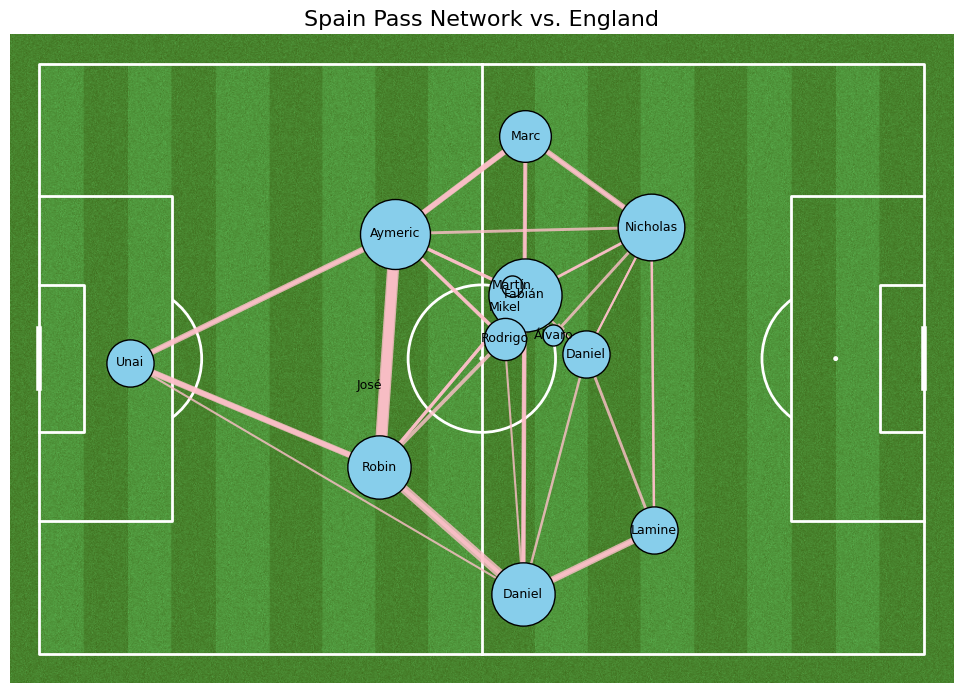


Top 5 players by degree centrality vs. England:
1. Fabián Ruiz Peña: 0.923
2. Aymeric Laporte: 0.846
3. Nicholas Williams Arthuer: 0.769
4. Robin Aime Robert Le Normand: 0.692
5. Daniel Carvajal Ramos: 0.692


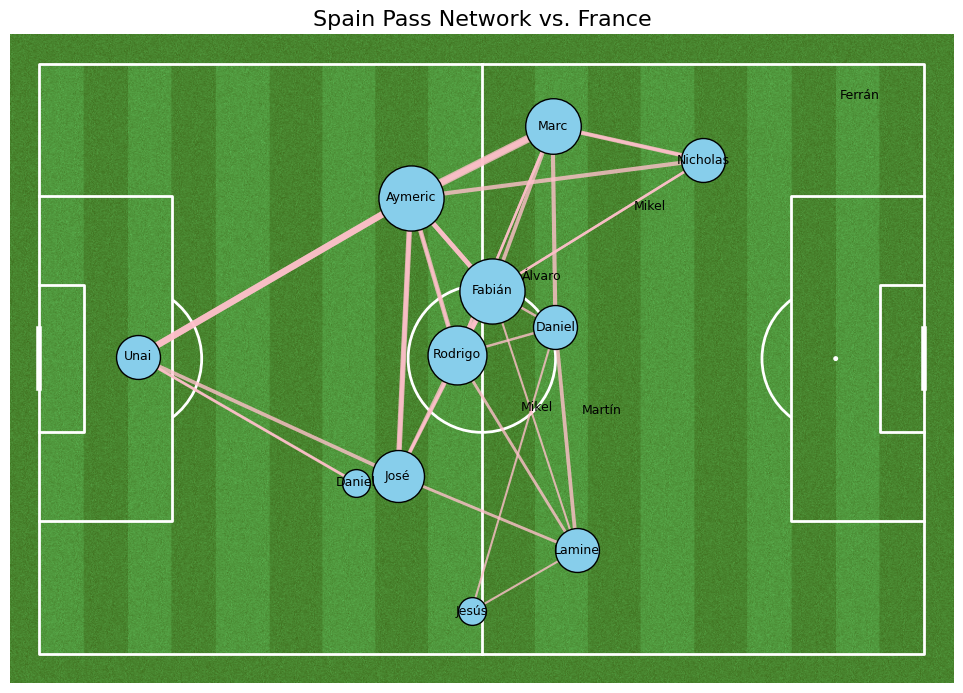


Top 5 players by degree centrality vs. France:
1. Aymeric Laporte: 0.733
2. Fabián Ruiz Peña: 0.733
3. Rodrigo Hernández Cascante: 0.600
4. Marc Cucurella Saseta: 0.533
5. José Ignacio Fernández Iglesias: 0.467


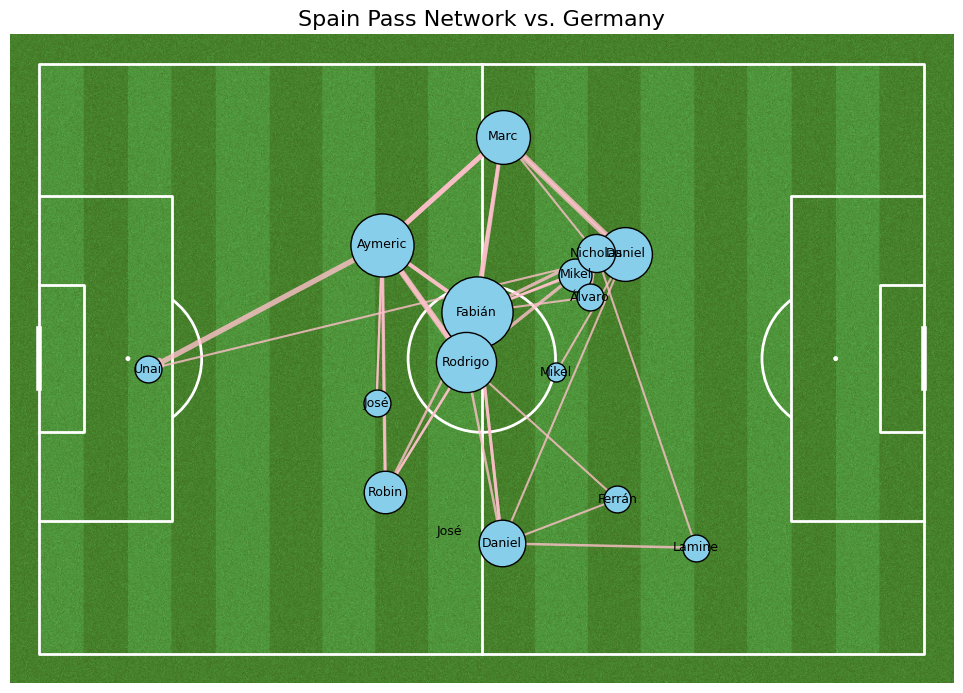


Top 5 players by degree centrality vs. Germany:
1. Fabián Ruiz Peña: 0.875
2. Aymeric Laporte: 0.688
3. Rodrigo Hernández Cascante: 0.625
4. Marc Cucurella Saseta: 0.500
5. Daniel Olmo Carvajal: 0.500


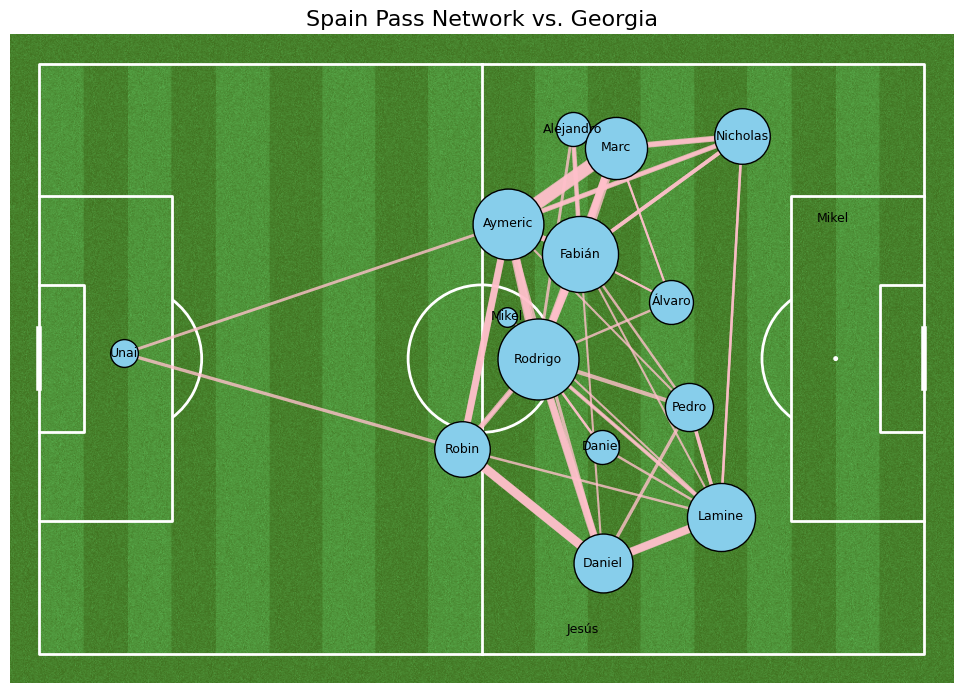


Top 5 players by degree centrality vs. Georgia:
1. Rodrigo Hernández Cascante: 1.133
2. Fabián Ruiz Peña: 1.000
3. Aymeric Laporte: 0.867
4. Lamine Yamal Nasraoui Ebana: 0.800
5. Marc Cucurella Saseta: 0.667


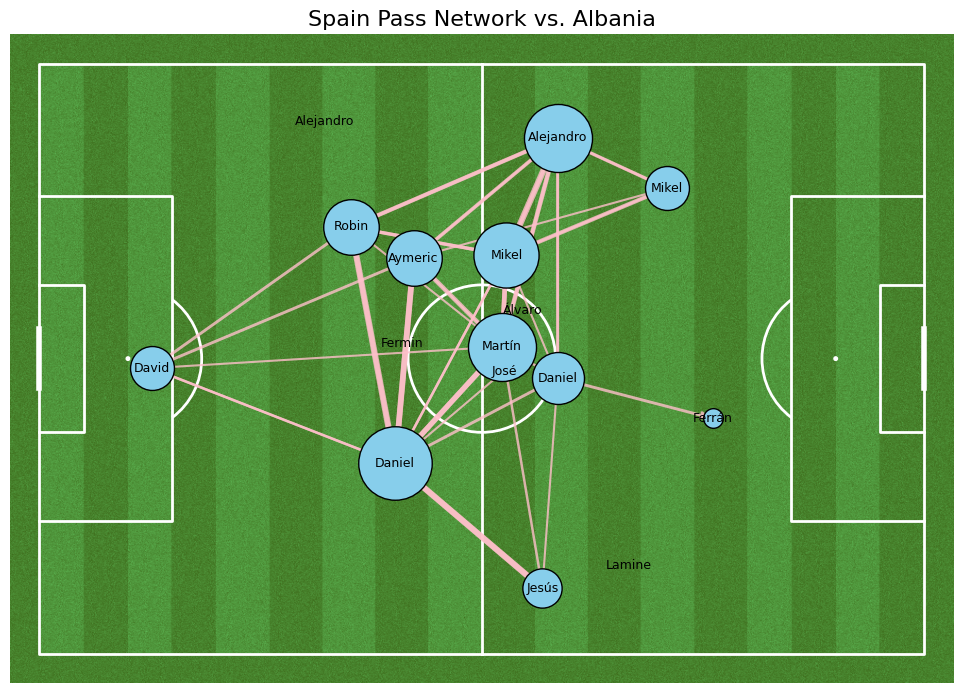


Top 5 players by degree centrality vs. Albania:
1. Daniel Vivian Moreno: 0.933
2. Martín Zubimendi Ibáñez: 0.800
3. Alejandro Grimaldo García: 0.800
4. Mikel Merino Zazón: 0.733
5. Aymeric Laporte: 0.533


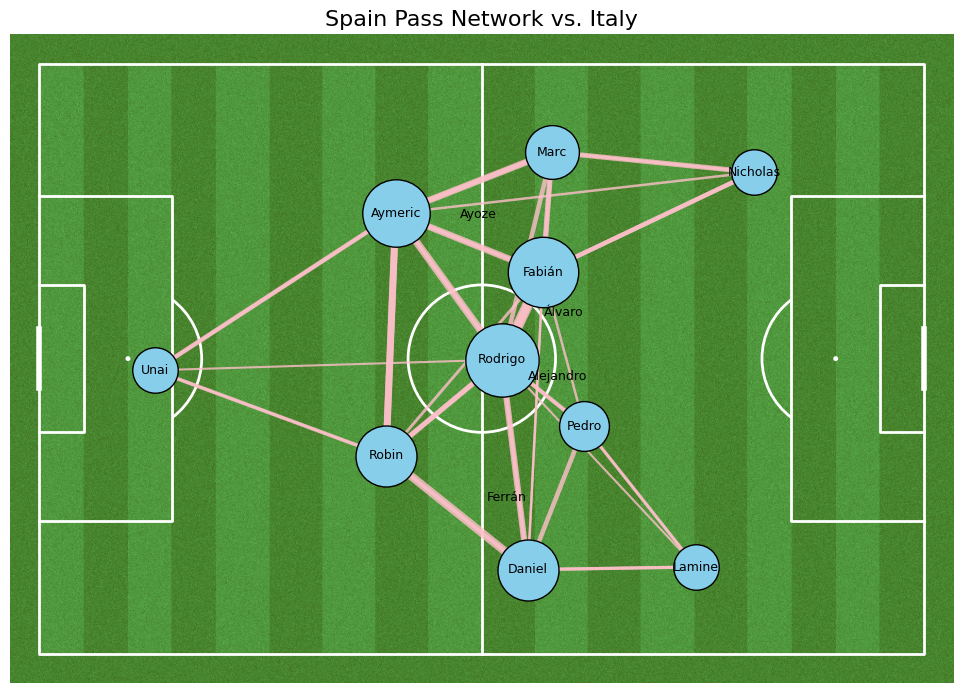


Top 5 players by degree centrality vs. Italy:
1. Rodrigo Hernández Cascante: 0.929
2. Fabián Ruiz Peña: 0.857
3. Aymeric Laporte: 0.786
4. Daniel Carvajal Ramos: 0.643
5. Robin Aime Robert Le Normand: 0.643


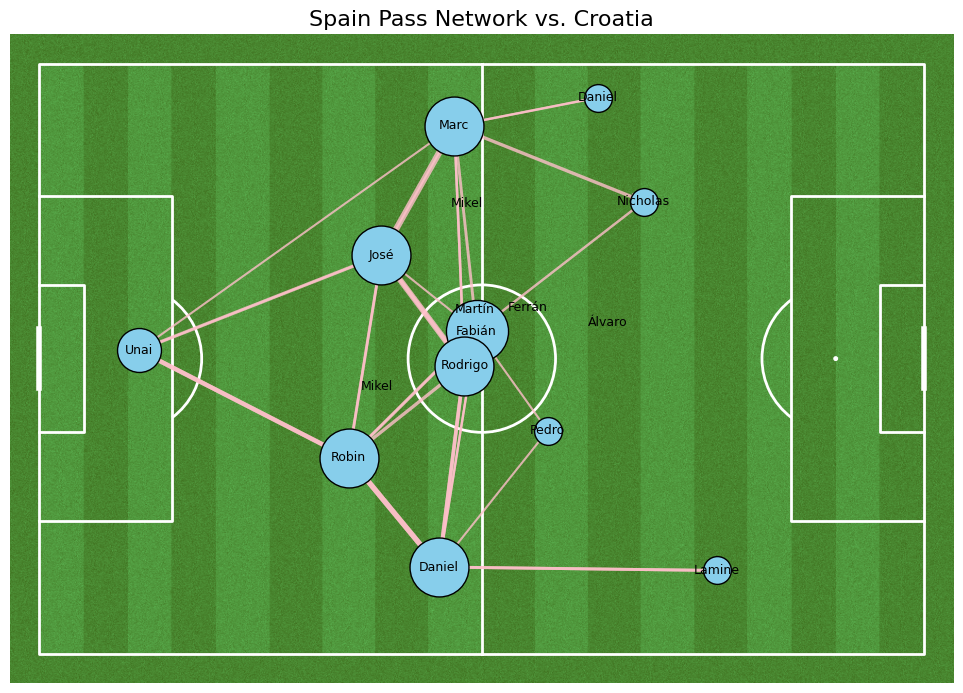


Top 5 players by degree centrality vs. Croatia:
1. Fabián Ruiz Peña: 0.667
2. Daniel Carvajal Ramos: 0.600
3. José Ignacio Fernández Iglesias: 0.600
4. Robin Aime Robert Le Normand: 0.600
5. Marc Cucurella Saseta: 0.600


In [64]:
centrality_records = []

for _, row in spain_matches.iterrows():
    match_id = row['match_id']
    team = 'Spain'
    opp_team = row['home_team'] if row['home_team'] != team else row['away_team']
    date = pd.to_datetime(row['match_date'])
    centrality = plot_pass_network(match_id,team)

    for player, score in centrality.items():
        centrality_records.append({
            'match_id': match_id,
            'date': date,
            'opponent': opp_team,
            'player': player,
            'degree_centrality': score
        })
    

In [81]:
events

match_id       date opponent                           player  \
99    3930160 2024-06-15  Croatia                 Fabián Ruiz Peña   
94    3930160 2024-06-15  Croatia            Daniel Carvajal Ramos   
96    3930160 2024-06-15  Croatia  José Ignacio Fernández Iglesias   
98    3930160 2024-06-15  Croatia     Robin Aime Robert Le Normand   
100   3930160 2024-06-15  Croatia            Marc Cucurella Saseta   

     degree_centrality  
99            0.666667  
94            0.600000  
96            0.600000  
98            0.600000  
100           0.600000